## 0. Setup Path

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPT_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH + '/images'
MODEL_PATH = WORKSPACE_PATH + '/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH + '/pretrained_model'
CONFIG_PATH = MODEL_PATH + '/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH + '/my_ssd_mobnet'

## 1. Create Label Map

In [2]:
labels = [{'name':'Mask','id':1},{'name':'noMask','id':2}]

In [3]:
labels

[{'name': 'Mask', 'id': 1}, {'name': 'noMask', 'id': 2}]

In [4]:
with open(ANNOTATION_PATH+'\label_map.pbtxt','w') as f:
    for label in labels:
        f.write('item{\n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## 2. Create TF records

In [5]:
!python {SCRIPT_PATH+'/generate_tfrecord.py'} -x {IMAGE_PATH+'/train'} -l {ANNOTATION_PATH+'/label_map.pbtxt'} -o {ANNOTATION_PATH+'/train.record'}
!python {SCRIPT_PATH+'/generate_tfrecord.py'} -x {IMAGE_PATH+'/train'} -l {ANNOTATION_PATH+'/label_map.pbtxt'} -o {ANNOTATION_PATH+'/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


## 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

## 4. Copy model config to training folder

In [6]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'

In [7]:
!mkdir {'Tensorflow\workspace\models\'+CUSTOM_MODEL_NAME}
!copy {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

The syntax of the command is incorrect.


## 5. Update Config For Transfer Learning

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [9]:
CONFIG_PATH = MODEL_PATH + '/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [10]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [20]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH,'r') as f:
    proto_str = f.read()
    text_format.Merge(proto_str,pipeline_config)

In [21]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [22]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)


## 6. Train the model

In [11]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=500""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=500


## 7. Load Train Model from Checkpoint

In [12]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [13]:
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'],is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH,'ckpt-8')).expect_partial()

In [14]:
@tf.function
def detect_fn(image):
    image, shapes= detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image,shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

## 8. Detect in Real-Time

In [15]:
import cv2
import numpy as np


In [16]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [17]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [18]:
while True:
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np,0),dtype = tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    
    detections = {key:value[0,:num_detections].numpy() for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    label_id_offset  =1 
    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
        detections['detection_boxes'],
        detections['detection_classes']+label_id_offset,
        detections['detection_scores'],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=1,
        min_score_thresh=0.7,
        agnostic_mode=False,
    )
    cv2.imshow('mask detection',cv2.resize(image_np_with_detections,(800,600)) )
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [22]:
IMAGE_PATH = os.path.join(IMAGE_PATH,'test','49883f9a-adc8-11eb-9cb1-7c763517992b.jpg')
import matplotlib.pyplot as plt
%matplotlib inline

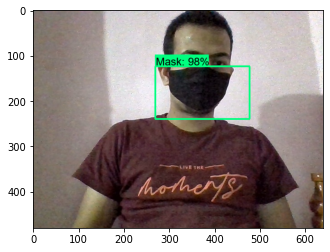

In [80]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np,0),dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key:value[0,:num_detections].numpy()
             for key,value in detections.items()}
detections['num_detections'] = num_detections

#detection_classes should be ints
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
image_np_with_detections,
detections['detection_boxes'],
detections['detection_classes']+label_id_offset,
detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=5,
    min_score_thresh=0.5,
    agnostic_mode=False
)
plt.imshow(cv2.cvtColor(image_np_with_detections,cv2.COLOR_BGR2RGB))
plt.show()